<a href="https://colab.research.google.com/github/srihari-humbarwadi/keras-io/blob/retinanet/examples/vision/ipynb/retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import OrderedDict
from functools import partial
import os
import zipfile

import numpy as np
import tensorflow as tf
from easydict import EasyDict

import matplotlib.pyplot as plt

logger = tf.get_logger()
logger.info('version : {}'.format(tf.__version__))

INFO:tensorflow:version : 2.2.0


#### Download the dataset

In [ ]:
url = 'https://raw.githubusercontent.com/srihari-humbarwadi/shapes_dataset/master/tfrecords.zip'
filename = os.path.join(os.getcwd(), 'shapes_tfrecords.zip')
tf.keras.utils.get_file(filename, url, extract=True, archive_format='zip')


with zipfile.ZipFile('shapes_tfrecords.zip', 'r') as z_fp:
    z_fp.extractall('./')

### Setting up Distrubution Strategy

In [3]:
def get_strategy(distribution_config):
    if (not distribution_config['use_gpu']) and (not distribution_config['use_tpu']):
        strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')
        logger.info('Running on CPU')

    elif distribution_config['use_gpu']:
        if not tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')
            logger.warning('No GPU found! Running on CPU')
        elif distribution_config['multi_gpu']:
            strategy = tf.distribute.MirroredStrategy()
            logger.info('Running with MirroredStrategy on {} GPU\'s '.format(strategy.num_replicas_in_sync))
        else:
            strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
            logger.info('Running on GPU')

    elif distribution_config['use_tpu']:
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver(distribution_config['tpu_name'])
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            logger.info('Running with TPUStrategy on TPU {} with {} cores '
                        .format(tpu.cluster_spec().as_dict()['worker'],
                                strategy.num_replicas_in_sync))
        except Exception:
            strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')
            logger.warning('Failed initializing TPU! Running on CPU')
    return strategy


distribution_config = {
    'use_gpu': True,
    'multi_gpu': False,
    'use_tpu': False,
    'tpu_name': ''
}

strategy = get_strategy(distribution_config)

INFO:tensorflow:Running on GPU


### Utility functions to deal with bounding boxes

In [ ]:
def convert_to_xywh(boxes):
    return tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0,
                      boxes[..., 2:] - boxes[..., :2]],
                     axis=-1)


def convert_to_corners(boxes):
    return tf.concat([
        boxes[..., :2] - boxes[..., 2:] / 2.0,
        boxes[..., :2] + boxes[..., 2:] / 2.0
    ], axis=-1)


def rescale_boxes(boxes, original_dims, new_dims):
    original_dims = tf.cast(original_dims, dtype=tf.float32)
    new_dims = tf.cast(new_dims, dtype=tf.float32)
    scale = new_dims / original_dims
    return tf.stack([
        boxes[..., 0]*scale[1],
        boxes[..., 1] * scale[0],
        boxes[..., 2]*scale[1],
        boxes[..., 3] * scale[0]
    ], axis=-1)


def relative_to_absolute(boxes, image_dims):
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0]*image_dims[1],
        boxes[..., 1] * image_dims[0],
        boxes[..., 2]*image_dims[1],
        boxes[..., 3] * image_dims[0]
    ], axis=-1)


def absolute_to_relative(boxes, image_dims):
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0] / image_dims[1],
        boxes[..., 1] / image_dims[0],
        boxes[..., 2] / image_dims[1],
        boxes[..., 3] / image_dims[0]
    ], axis=-1)


def swap_xy(boxes):
    return tf.stack([
        boxes[:, 1],
        boxes[:, 0],
        boxes[:, 3],
        boxes[:, 2],
    ], axis=-1)


### Function to visualize detections

In [ ]:
def visualize_detections(image,
                         boxes,
                         classes=None,
                         scores=None,
                         figsize=(7, 7),
                         linewidth=1,
                         color=[.1, .1, .4],
                         show_labels=True):
    image = np.array(image, dtype=np.uint8)
    figure = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()
    ax.margins(0)
    
    if classes is None:
        classes = ['' for _ in range(len(boxes))]
        scores = ['' for _ in range(len(boxes))]
        show_labels = False
    
    for box, _cls, score in zip(boxes, classes, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle([x1, y1],
                              w,
                              h,
                              fill=False,
                              edgecolor=color,
                              linewidth=linewidth)
        ax.add_patch(patch)
        if show_labels:
            text = '{}: {:.2f}'.format(_cls, score)
            ax.text(x1,
                    y1,
                    text,
                    bbox={
                        'facecolor': color,
                        'alpha': 0.4
                    },
                    clip_box=ax.clipbox,
                    clip_on=True)
    plt.show()
    return figure

### Building Anchor Boxes
 - For each feature map in the feature pyramid, we have nine anchor boxes
    </br>at each location of the feature map.
 - At each location, we have anchor boxes with three aspect ratios and
    </br>three different scales.
 - Default ratios: [0.5, 1, 2]
 - Default scales: [2^0, 2^(1 / 3), 2^(2 / 3)]
 - Total number of anchor boxes at each feature map: fh * fw * 9
    </br>where fh & fw are the height and width of the feature map.

In [ ]:
class AnchorBoxes:

    def __init__(self, config):
        self.input_height = config.image_height
        self.input_width = config.image_width

        self.areas = config.anchor_areas
        self.scales = config.anchor_scales
        self.aspect_ratios = config.anchor_aspect_ratios
        self.strides = [8, 16, 32, 64, 128]
        self._anchor_boxes = []
        self._build_anchor_boxes()

    def _get_centers(self, feature_size, stride):
        rx = tf.range(feature_size[1], dtype=tf.float32)
        ry = tf.range(feature_size[0], dtype=tf.float32)
        centers = tf.stack(tf.meshgrid((0.5 + rx) * stride,
                                       (0.5 + ry) * stride),
                           axis=-1)
        return tf.cast(centers, dtype=tf.float32)

    def _get_dims(self, area, ratio):
        h = np.sqrt(area / ratio)
        w = area / h
        wh = tf.constant([w, h], dtype=tf.float32, shape=[1, 1, 2])
        return wh

    def _build_anchor_boxes(self):
        anchor_boxes = []
        for i in range(len(self.strides)):
            stride = self.strides[i]
            area = self.areas[i]
            feature_size = (self.input_height // stride,
                            self.input_width // stride)
            centers = self._get_centers(feature_size, stride)
            anchor_box = []
            for ratio in self.aspect_ratios:
                wh = self._get_dims(area, ratio)
                wh = tf.tile(wh,
                             multiples=[feature_size[0], feature_size[1], 1])
                for scale in self.scales:
                    scaled_wh = wh * scale
                    box = tf.concat([centers, scaled_wh], axis=-1)
                    box = tf.expand_dims(box, axis=-2)
                    anchor_box.append(box)
            anchor_box = tf.concat(anchor_box, axis=2)
            anchor_box = tf.reshape(anchor_box, shape=[-1, 4])
            anchor_boxes.append(anchor_box)
        self._anchor_boxes = tf.concat(anchor_boxes, axis=0)

    @property
    def boxes(self):
        return self._anchor_boxes

### Matching ground truth boxes with anchor boxes
 - We compute pair wise IOU between the anchor boxes and
    </br>ground truth boxes.
 - For each anchor box, the ground truth box with the highest
    </br>IOU is assigned to it.
 - Anchor boxes that have IOU < 0.4 are assigned with the background class.
 - Achor boxes that have IOU >= 0.4 and < 0.5 are ignored in classification
     </br>loss computation.
 - For bounding box regression, we only use the anchor boxes with
    </br>IOU >= 0.5 for loss computation.
 - Each anchor box can be assigned a single ground truth box.
 - A single ground truth box may be assigned to multiple anchor boxes.

In [ ]:
class BoxMatcher:

    def __init__(self, config):
        self.match_iou_threshold = config.match_iou_threshold
        self.ignore_iou_threshold = config.ignore_iou_threshold

    def _compute_iou(self, boxes1, boxes2):
        boxes1_corners = convert_to_corners(boxes1)
        boxes2_corners = convert_to_corners(boxes2)

        lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
        rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])

        intersection = tf.maximum(0.0, rd - lu)
        intersection_area = intersection[:, :, 0] * intersection[:, :, 1]

        boxes1_area = boxes1[:, 2] * boxes1[:, 3]
        boxes2_area = boxes2[:, 2] * boxes2[:, 3]

        union_area = tf.maximum(
            boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
        return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

    def __call__(self, default_boxes, gt_boxes):
        iou_matrix = self._compute_iou(default_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, self.match_iou_threshold)
        negative_mask = tf.less_equal(max_iou, self.ignore_iou_threshold)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask,
                                                   negative_mask))
        return (matched_gt_idx,
                tf.cast(positive_mask, dtype=tf.float32),
                tf.cast(ignore_mask, dtype=tf.float32))

### Encoding the labels
 -  The target label for RetinaNet has two parts
     - Box targets: For each of the localtion on the feature map
         </br>the anchor boxes are responsible to regress 4 values.
     - Classification targets: For each of the localtion on the feature map
         </br>the anchor boxes are also responsible to predict probablities for the K classes.
         
         
 - Encoding Box targets:
     - Let [x, y, w, h] and [xa, ya, wa, ha] represent the assigned
        </br>ground truth and the anchor box respectively and [tx, ty, tw, th] be the target.
     </br> The targets can be computed as follows.
     - tx = (x - xa) / wa
     - ty = (y - ya) / wh
     - tw = log(w / wa)
     - th = log(h / ha)
     
     
 - Encoding the classification targets:
     - We only encode classification targets as cls_ids, as we will be expanding
         </br>them as one hot labels during the loss computation.
     - The Anchor boxes assigned with the background class are encoded as -1
     - Anchor boxes that are supposed to be ignored are encoded as -2
     - The remaining anchor boxes are encoded with the cls_ids of the assigned
         </br>ground truth box.

In [ ]:
class LabelEncoder:

    def __init__(self, config):
        self.num_classes = config.num_classes
        self.box_variance = tf.constant(config.box_variance, dtype=tf.float32)
        self._anchor_boxes = AnchorBoxes(config).boxes
        self._box_matcher = BoxMatcher(config)

    def _compute_box_target(self, matched_gt_boxes):
        box_target = tf.concat(
            [(matched_gt_boxes[:, :2] - self._anchor_boxes[:, :2]) /
             self._anchor_boxes[:, 2:],
             tf.math.log(matched_gt_boxes[:, 2:] / self._anchor_boxes[:, 2:])],
            axis=-1)
        box_target = box_target / self.box_variance
        return box_target

    def encode_sample(self, gt_boxes, cls_ids):
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)

        matched_gt_idx, positive_mask, ignore_mask = \
            self._box_matcher(self._anchor_boxes, gt_boxes)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(matched_gt_boxes)

        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0),
                              -1.0,
                              matched_gt_cls_ids)
        cls_target = tf.where(tf.equal(ignore_mask, 1.0),
                              -2.0,
                              cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

### Building the tf.data pipeline
 - For efficient data loading, the dataset has been converted into tfrecords.
 - The tfrecords  has have the following features:
     - image: path to the image file
     - xmins: ymins, xmaxs, ymaxs: Represent the bounding boxes of the objects
     - classes: Integer class ids for of the objects

In [ ]:
class DatasetBuilder:

    def __init__(self, split, config):
        self.split = split
        self._label_encoder = LabelEncoder(config)
        self.input_height = config.image_height
        self.input_width = config.image_width
        self.batch_size = config.batch_size
        self.mean_pixel = tf.constant(config.mean_pixel, dtype=tf.float32)
        self.flip_lr = config.augmentation.flip_lr
        self.cache_dataset_in_memory = config.cache_dataset_in_memory

        self._dataset = None
        self._tfrecords = tf.data.Dataset.list_files(config.tfrecords[split])
        self._build_tfrecord_dataset()

    def _random_flip_lr(self, image, boxes):
        '''flip the image and boxes horizontally with 50% chance'''
        w = tf.cast(tf.shape(image)[1], dtype=tf.float32)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            boxes = tf.stack(
                [w - boxes[:, 2], boxes[:, 1], w - boxes[:, 0], boxes[:, 3]],
                axis=-1)
        return image, boxes

    def _pad_to_square_fn(self, image, boxes):
        '''
        Pads the image with zeros to make it a
        square with side equal the largest side
        '''
        dims = tf.shape(image)
        image_height = dims[0]
        image_width = dims[1]

        side = tf.maximum(image_height, image_width)
        if tf.random.uniform(()) > 0.5:
            offset_x = 0
            offset_y = 0
        else:
            if image_height < image_width:
                offset_x = 0
                offset_y = side - image_height
            else:
                offset_x = side - image_width
                offset_y = 0
        padded_image = tf.image.pad_to_bounding_box(image, offset_y, offset_x, side, side)

        offset_x = tf.cast(offset_x, dtype=tf.float32)
        offset_y = tf.cast(offset_y, dtype=tf.float32)
        offset_boxes = tf.stack([
            boxes[:, 0] + offset_x,
            boxes[:, 1] + offset_y,
            boxes[:, 2] + offset_x,
            boxes[:, 3] + offset_y,
        ], axis=-1)
        return padded_image, offset_boxes

    def _parse_example(self, example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'xmins': tf.io.VarLenFeature(tf.float32),
            'ymins': tf.io.VarLenFeature(tf.float32),
            'xmaxs': tf.io.VarLenFeature(tf.float32),
            'ymaxs': tf.io.VarLenFeature(tf.float32),
            'classes': tf.io.VarLenFeature(tf.int64),
        }

        parsed_example = tf.io.parse_single_example(example_proto,
                                                    feature_description)

        classes = tf.sparse.to_dense(parsed_example['classes'])

        image = tf.io.decode_image(parsed_example['image'], channels=3)
        image = tf.cast(image, dtype=tf.float32)
        image.set_shape([None, None, 3])

        boxes = tf.stack([
            tf.sparse.to_dense(parsed_example['xmins']),
            tf.sparse.to_dense(parsed_example['ymins']),
            tf.sparse.to_dense(parsed_example['xmaxs']),
            tf.sparse.to_dense(parsed_example['ymaxs']),
        ], axis=-1)
        boxes = tf.cast(boxes, dtype=tf.float32)
        return image, boxes, classes

    def _parse_and_create_label(self, example_proto):
        '''Parse the tfrecord and create the targets'''
        image, boxes, classes = self._parse_example(example_proto)
        original_dims = tf.cast(tf.shape(image), dtype=tf.float32)
        boxes = tf.stack([
            tf.clip_by_value(boxes[..., 0], 0, original_dims[1]),
            tf.clip_by_value(boxes[..., 1], 0, original_dims[0]),
            tf.clip_by_value(boxes[..., 2], 0, original_dims[1]),
            tf.clip_by_value(boxes[..., 3], 0, original_dims[0])
        ], axis=-1)
        image = image[:, :, ::-1] - self.mean_pixel
        image, boxes = self._pad_to_square_fn(image, boxes)
        new_dims = tf.shape(image)
        image = tf.image.resize(image,
                                size=[self.input_height, self.input_width])

        boxes = rescale_boxes(boxes,
                              [new_dims[0], new_dims[1]],
                              [self.input_height, self.input_width])

        if self.flip_lr:
            image, boxes = self._random_flip_lr(image, boxes)

        boxes_xywh = convert_to_xywh(boxes)
        label = self._label_encoder.encode_sample(boxes_xywh, classes)
        return image, label

    def _build_tfrecord_dataset(self):
        _options = tf.data.Options()
        _options.experimental_deterministic = False
        _autotune = tf.data.experimental.AUTOTUNE
        
        dataset = self._tfrecords.interleave(
            tf.data.TFRecordDataset,
            cycle_length=8,
            block_length=4,
            num_parallel_calls=_autotune)
        dataset = dataset.with_options(_options)
        if self.cache_dataset_in_memory:
            dataset = dataset.cache()
        dataset = dataset.shuffle(8*self.batch_size)
        dataset = dataset.map(self._parse_and_create_label,
                              num_parallel_calls=_autotune)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(_autotune)
        self._dataset = dataset

    @property
    def dataset(self):
        return self._dataset

### Implementing a custom layer to decode the predictions

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(self, config, **kwargs):
        self._from_logits = kwargs.pop('from_logits', True)
        super(DecodePredictions, self).__init__(**kwargs)
        self.input_height = config.image_height
        self.input_width = config.image_width
        self.confidence_threshold = config.confidence_threshold
        self.nms_iou_threshold = config.nms_iou_threshold
        self.max_detections = config.max_detections
        self.top_k_boxes = config.top_k_boxes
        self.box_variance = config.box_variance

        self._anchor_boxes = AnchorBoxes(config).boxes
        self.built = True

    def _decode_box_predictions(self, box_predictions):
        # box_predictions.shape == [None, A, 4]
        boxes = box_predictions * self.box_variance
        boxes = tf.concat([
            boxes[:, :2] * self._anchor_boxes[:, 2:] +
            self._anchor_boxes[:, :2],
            tf.math.exp(boxes[:, 2:]) * self._anchor_boxes[:, 2:]
        ],
            axis=-1)
        boxes_transformed = convert_to_corners(boxes)
        boxes_transformed = tf.stack([
            tf.clip_by_value(boxes_transformed[:, 0], 0, self.input_width),
            tf.clip_by_value(boxes_transformed[:, 1], 0, self.input_height),
            tf.clip_by_value(boxes_transformed[:, 2], 0, self.input_width),
            tf.clip_by_value(boxes_transformed[:, 3], 0, self.input_height),
        ],
            axis=-1)
        # boxes_transformed.shape == [None, A, 4]
        return boxes_transformed

    def _decode_cls_predictions(self, cls_predictions):
        # cls_predictions.shape == [None, A, num_classes]
        if self._from_logits:
            cls_predictions = tf.nn.sigmoid(cls_predictions)
        cls_probs = tf.reduce_max(cls_predictions, axis=-1)
        cls_ids = tf.argmax(cls_predictions, axis=-1)
        return cls_ids, cls_probs

    def _filter_top_k(self, boxes, cls_ids, cls_probs):
        filtered_cls_probs, idx = tf.nn.top_k(cls_probs, k=self.top_k_boxes)
        filtered_boxes = tf.gather(boxes, idx)
        filtered_cls_ids = tf.gather(cls_ids, idx)
        return filtered_boxes, filtered_cls_ids, filtered_cls_probs

    def call(self, predictions):
        #    predictions.shape == [1, A, (4 + num_classes)]
        predictions = predictions[0]  # Batch decoding is not supported
        box_predictions = predictions[:, :4]
        cls_predictions = predictions[:, 4:]

        cls_ids, cls_probs = self._decode_cls_predictions(cls_predictions)
        boxes = self._decode_box_predictions(box_predictions)
        boxes, cls_ids, cls_probs = self._filter_top_k(boxes, cls_ids, cls_probs)

        nms_idx = tf.image.non_max_suppression(swap_xy(boxes), cls_probs,
                                               self.max_detections,
                                               self.nms_iou_threshold,
                                               self.confidence_threshold)
        detections = {
            'boxes': tf.gather(boxes, nms_idx),
            'cls_ids': tf.gather(cls_ids, nms_idx),
            'cls_probs': tf.gather(cls_probs, nms_idx)
        }
        return detections

#### Smooth L1 loss for box outputs

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(reduction='none',
                                               name='RetinaNetBoxLoss')
        self._delta = delta

    def call(self, y_true, y_pred):
        loss = tf.compat.v1.losses.huber_loss(labels=y_true,
                                              predictions=y_pred,
                                              delta=self._delta,
                                              reduction='none')
        loss = tf.reduce_sum(loss, axis=-1)
        return loss

#### Focal loss for classification outputs

In [ ]:
class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss,
              self).__init__(reduction='none',
                             name='RetinaNetClassificationLoss')
        self._alpha = alpha
        self._gamma = gamma

    def _focal_loss(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,
                                                                logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0),
                        self._alpha,
                        (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

    def call(self, y_true, y_pred):
        return self._focal_loss(y_true, y_pred)

#### Implementing a wrapper to normalize both losses

In [ ]:
class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes, alpha, gamma, delta):
        super(RetinaNetLoss, self).__init__(reduction='none',
                                            name='RetinaNetLoss')
        self._cls_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes
        
    def call(self, y_true, y_pred):
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        
        cls_labels = tf.one_hot(tf.cast(y_true[:, :, 4], dtype=tf.int32),
                                depth=self._num_classes,
                                dtype=tf.float32)
        cls_predictions = y_pred[:, :, 4:]
        
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions) #  [None, A]
        box_loss = self._box_loss(box_labels, box_predictions) #  [None, A]

        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        # Number of positive anchor boxes for each sample in the batch
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        
        # tf.math.divide_no_nan returns 0 if divide by zero occurs
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        return cls_loss, box_loss

### Building FPN

In [ ]:
def conv2d(inputs,
               filters,
               kernel_size,
               strides,
               kernel_initializer='he_normal',
               bias_initializer='zeros',
               name=None):
    return tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=kernel_size,
                                  padding='same',
                                  strides=strides,
                                  kernel_initializer=kernel_initializer,
                                  bias_initializer=bias_initializer,
                                  name=name)(inputs)


def build_backbone(input_height, input_width):
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[input_height, input_width, 3])

    C3, C4, C5 = [
        backbone.get_layer(layer_name).output for layer_name in
        ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    ]
    return backbone, (C3, C4, C5)


def get_feature_pyramid(features):
    _upsample = partial(tf.keras.layers.UpSampling2D,
                        size=2,
                        interpolation='nearest')
    
    # P6 is obtained via a 3×3 stride-2 conv on C5, and P7 is computed
    # by applying ReLU followed by a 3×3 stride-2 conv on P6.

    P6 = conv2d(features[-1], 256, 3, 2, name='P6')
    P6_relu = tf.keras.layers.ReLU(name='P6_relu')(P6)
    P7 = conv2d(P6_relu, 256, 3, 2, name='P7')

    # lateral connections
    features = [
        conv2d(feature, 256, 1, 1, name=f'C{i+3}_projection')
        for i, feature in enumerate(features)
    ]

    P5 = conv2d(features[2], 256, 3, 1, name='P5')
    P4 = tf.keras.layers.Add(name='P4_P5UP')(
        [features[1], _upsample(name='P5_upsample')(features[2])])
    P4 = conv2d(P4, 256, 3, 1, name='P4')
    P3 = tf.keras.layers.Add(name='P3_P4UP')(
        [features[0], _upsample(name='P4_upsample')(features[1])])
    P3 = conv2d(P3, 256, 3, 1, name='P3')

    return [P3, P4, P5, P6, P7]

#### Loss utils

In [ ]:
def _safe_mean(losses):
    '''compute mean, avoids divide by zero'''
    num_values = tf.cast(tf.size(losses), dtype=tf.float32)
    return tf.math.divide_no_nan(tf.reduce_sum(losses), num_values)


def _scale_loss(loss):
    '''returns scaled loss, used when training with all-reduce'''
    strategy = tf.distribute.get_strategy()
    num_replicas = strategy.num_replicas_in_sync
    return loss * (1. / num_replicas)


def get_scaled_losses(loss, regularization_losses=None):
    '''returns scaled losses that can be used in optizimer.apply_gradients'''
    loss = _scale_loss(_safe_mean(loss))
    if regularization_losses:
        regularization_losses = tf.math.add_n(regularization_losses)
        regularization_losses = _scale_loss(regularization_losses)
        loss = loss + regularization_losses
    return loss


def reduce_losses(losses_dict):
    return {loss: _safe_mean(value) for loss, value in losses_dict.items()}

### Building RetinaNet

In [ ]:
class RetinaNet(tf.keras.Model):
    def __init__(self, config, **kwargs):
        super(RetinaNet, self).__init__(**kwargs)
        self.input_height = config.image_height
        self.input_width = config.image_width
        self.num_classes = config.num_classes
        self.l2_regularization = config.l2_regularization

        self._network = self._build_retinanet()
        self._decode_predictions = DecodePredictions(config)

    def compile(self, loss_fn, optimizer, **kwargs):
        super(RetinaNet, self).compile(**kwargs)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def call(self, inputs, training):
        return self._network(inputs, training=training)

    def train_step(self, data):
        images, y_true = data[0], data[1]

        with tf.GradientTape() as tape:
            # set training to True so that batch norms layers update their weights
            y_pred = self(images, training=True)
            loss_values = self.loss_fn(y_true, y_pred)
            cls_loss = loss_values[0]
            box_loss = loss_values[1]

            loss = cls_loss + box_loss
            
            # get regularization losses
            regularization_losses = self.losses

            # all-reduce sums gradients from each replica so we scale the
            # loss to take this into account
            _scaled_losses = get_scaled_losses(loss, regularization_losses)

        gradients = tape.gradient(_scaled_losses, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        loss_dict = OrderedDict({
            'total_loss': loss,
            'cls_loss': cls_loss,
            'box_loss': box_loss,
        })

        if self.l2_regularization:
            loss_dict['regularization_losses'] = regularization_losses

        # average all losses, these are tracked and displayed by the fit method
        return reduce_losses(loss_dict)

    def test_step(self, data):
        images, y_true = data[0], data[1]

        # set training to True so that batch norms layers don't update their weights
        y_pred = self(images, training=False)
        loss_values = self.loss_fn(y_true, y_pred)
        cls_loss = loss_values[0]
        box_loss = loss_values[1]

        loss = cls_loss + box_loss

        loss_dict = OrderedDict({
            'total_loss': loss,
            'cls_loss': cls_loss,
            'box_loss': box_loss,
        })

        # average all losses, these are tracked and displayed by the fit method
        return reduce_losses(loss_dict)

    def predict_step(self, data):
        '''overide the predict_step, so that we can directly get the detections'''
        images = data[0]

        # set training to True so that batch norms layers don't update their weights
        predictions = self.call(images, training=False)
        return self._decode_predictions(predictions)

    @tf.function
    def get_detections(self, images):
        '''tf.function decorated function that can be exported in the saved_model'''
        return self.predict_step((images,))

    def _get_box_head_layers(self):
        '''Get the shared conv2d layers for the box head'''
        conv_layers = []
        for i in range(4):
            conv_layers += [
                tf.keras.layers.Conv2D(
                    filters=256,
                    kernel_size=3,
                    padding='same',
                    kernel_initializer=tf.initializers.RandomNormal(0.0, 0.01),
                    bias_initializer=tf.initializers.zeros(),
                    name=f'box_head_shared_conv_{i+1}')
            ]
        conv_layers += [
            tf.keras.layers.Conv2D(
                filters=9 * 4,
                kernel_size=3,
                padding='same',
                kernel_initializer=tf.initializers.RandomNormal(0.0, 1e-5),
                bias_initializer=tf.initializers.zeros(),
                name='box_head_shared_prediction_conv')
        ]
        return conv_layers

    def _build_box_head(self, feature_pyramid):
        '''Building the box head, this is shared between all the feature levels'''
        box_predictions = []
        conv_layers = self._get_box_head_layers()
        for feature in feature_pyramid:
            _, fh, fw, _ = feature.get_shape()
            x = feature
            for i, conv_layer in enumerate(conv_layers[:-1]):
                x = conv_layer(x)
                name_bn = feature.name[:2] + f'_box_head_bn_{i+1}'
                name_relu = feature.name[:2] + f'_box_head_relu_{i+1}'

                #  Each feature level has its own batch norm layer.
                #  Unlike the conv2d layers, this is not shared because
                #  the batch statistics are not the same for each feature level
                #  We learn this independently at each feature level.

                x = tf.keras.layers.BatchNormalization(name=name_bn)(x)
                x = tf.keras.layers.ReLU(name=name_relu)(x)
            x = conv_layers[-1](x)
            x = tf.keras.layers.Reshape([fh * fw * 9, 4],
                                        name=feature.name[:2] +
                                        '_box_predictions_reshape')(x)
            box_predictions.append(x)
        box_predictions = tf.keras.layers.Concatenate(
            axis=1, name='box_head_predictions')(box_predictions)
        return box_predictions

    def _get_cls_head_layers(self):
        '''Get the shared conv2d layers for the classification head'''
        conv_layers = []
        for i in range(4):
            conv_layers += [
                tf.keras.layers.Conv2D(
                    filters=256,
                    kernel_size=3,
                    padding='same',
                    kernel_initializer=tf.initializers.RandomNormal(0.0, 0.01),
                    bias_initializer=tf.initializers.zeros(),
                    name=f'cls_head_shared_conv_{i+1}')
            ]

        # initialize the weights of the the predictions layer such that, it assigns
        # the probability of 0.01 to all the anchor boxes. This avoids large gradients
        # in the early stages of training, since most of the locations belong to
        # the background class.
        conv_layers += [
            tf.keras.layers.Conv2D(
                filters=9 * self.num_classes,
                kernel_size=3,
                padding='same',
                kernel_initializer=tf.initializers.RandomNormal(0.0, 1e-5),
                bias_initializer=tf.constant_initializer(-np.log((1 - 0.01) /
                                                                 0.01)),
                name='cls_head_shared_prediction_conv')
        ]
        return conv_layers

    def _build_cls_head(self, feature_pyramid):
        '''Building the box head, this is shared between all the feature levels'''
        cls_predictions = []
        conv_layers = self._get_cls_head_layers()
        for feature in feature_pyramid:
            _, fh, fw, _ = feature.get_shape()
            x = feature
            for i, conv_layer in enumerate(conv_layers[:-1]):
                x = conv_layer(x)
                name_bn = feature.name[:2] + f'_cls_head_bn_{i+1}'
                name_relu = feature.name[:2] + f'_cls_head_relu_{i+1}'

                #  Each feature level has its own batch norm layer.
                #  Unlike the conv2d layers, this is not shared because
                #  the batch statistics are not the same for each feature level
                #  We learn this independently at each feature level.

                x = tf.keras.layers.BatchNormalization(name=name_bn)(x)
                x = tf.keras.layers.ReLU(name=name_relu)(x)
            x = conv_layers[-1](x)
            x = tf.keras.layers.Reshape([fh * fw * 9, self.num_classes],
                                        name=feature.name[:2] +
                                        '_cls_predictions_reshape')(x)
            cls_predictions.append(x)
        cls_predictions = tf.keras.layers.Concatenate(
            axis=1, name='cls_head_predictions')(cls_predictions)
        return cls_predictions

    def _build_retinanet(self):

        def add_l2_regularization(layer):
            '''returns callable, to be called by model.get_losses'''
            l2_reg = tf.keras.regularizers.l2(self.l2_regularization)

            def _add_l2_regularization():
                return l2_reg(layer.kernel)
            return _add_l2_regularization

        backbone, features = build_backbone(self.input_height,
                                            self.input_width)
        feature_pyramid = get_feature_pyramid(features)

        box_predictions = self._build_box_head(feature_pyramid)
        classification_predictions = self._build_cls_head(feature_pyramid)

        predictions = tf.keras.layers.Concatenate(axis=-1,
                                                  name='predictions')([
                                                      box_predictions,
                                                      classification_predictions
                                                  ])
        model = tf.keras.Model(inputs=[backbone.input], outputs=[predictions])

        # Adding l2 regularization using add_loss function
        if self.l2_regularization:
            for layer in model.layers:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    if hasattr(layer, 'kernel'):
                        layer.add_loss(add_l2_regularization(layer))
        return model

In [ ]:
config = EasyDict({
    'image_height': 640,
    'image_width': 640,

    'num_classes': 2,
    'classes': ['circle', 'rectangle'],

    # If running with TPUs make sure you store your tfrecords on a google storage bucket
    'tfrecords': {
        'train': './tfrecords/train*',
        'validation': './tfrecords/val*',
    },
    'num_train_samples': 10000,
    'num_val_samples': 2500,
    
    'box_variance': [0.1, 0.1, 0.2, 0.2],
    'match_iou_threshold': 0.5,
    'ignore_iou_threshold': 0.4,
    'anchor_areas': [32.0**2, 64.0**2, 128.0**2, 256.0**2, 512.0**2],
    'anchor_aspect_ratios': [1/2, 1.0, 2.0],
    'anchor_scales': [2**0, 2**(1 / 3), 2**(2 / 3)],

    'cache_dataset_in_memory': True,
    'mean_pixel': [103.939, 116.779, 123.68],

    'batch_size': 4,
    'scale_batch_size': True,
    'train_steps': 2500,
    
    'l2_regularization': 1e-4,

    'decay_learning_rate': False,
    'base_learning_rate': 0.001,
    'learning_rates': [0.001, 0.0005],
    'learning_boundaries': [1250],
    'momentum': 0.9,

    'confidence_threshold': 0.5,
    'top_k_boxes': 1000,
    'nms_iou_threshold': 0.5,
    'max_detections': 100,
    
    'augmentation': {
        'flip_lr': True
    },
    
    # If running with TPUs make sure you store your model files on a google storage bucket
    'model_dir': './model_files'
})

In [ ]:
# Linearly scale the batch size to account for multiple replicas 
if config.scale_batch_size:
    config.batch_size *= strategy.num_replicas_in_sync

with strategy.scope():
    train_dataset = DatasetBuilder('train', config)
    val_dataset = DatasetBuilder('validation', config)

In [ ]:
for batch in val_dataset.dataset.take(1):
    images = (batch[0] + config.mean_pixel)[:, :, :, ::-1]
    labels = batch[1]
    reg_labels, cls_labels = labels[:, :, :4], labels[:, :, 4]
    positive_mask = tf.cast(tf.greater(cls_labels, -1.0), dtype=tf.float32)[0]
    ignore_mask = tf.cast(tf.equal(cls_labels, -2.0), dtype=tf.float32)[0]
    cls_labels = tf.one_hot(tf.cast(cls_labels, dtype=tf.int32),
                            depth=config.num_classes,
                            dtype=tf.float32)
    labels = tf.concat([reg_labels, cls_labels], axis=-1)

#### Visualizing matched anchor boxes
Making sure the target encoding works as expected

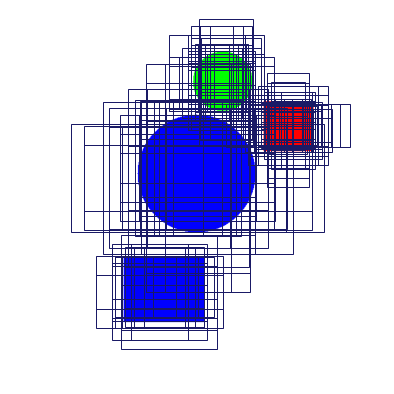

INFO:tensorflow:Positive anchors: 166


In [20]:
matched_anchor_boxes = convert_to_corners(tf.gather(val_dataset._label_encoder._anchor_boxes,
                                 tf.where(tf.equal(positive_mask, 1.0))[:, 0]))
num_positive_anchors = tf.math.count_nonzero(positive_mask)
fig = visualize_detections(images[0], matched_anchor_boxes)
logger.info('Positive anchors: {}'.format(num_positive_anchors))

### Visualizing decoded boxes
Making sure the DecodePredictions layer works as expected

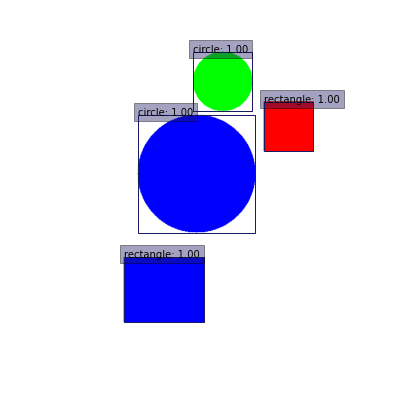

In [21]:
detections = DecodePredictions(config, from_logits=False)(labels)
classes = [config['classes'][idx] for idx in detections['cls_ids'].numpy()]
fig = visualize_detections(images[0], detections['boxes'], classes, detections['cls_probs'].numpy())

In [ ]:
def get_optimizer(config):
    momentum = config.momentum
    if config.decay_learning_rate:
        learning_rate = \
        tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=config.learning_boundaries,
                                                       learning_rates=config.learning_rates)
    else:
        learning_rate = config.base_learning_rate
    return tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

In [ ]:
train_steps_per_epoch = config.num_train_samples // config.batch_size
val_steps_per_epoch = config.num_val_samples // config.batch_size

epochs = config.train_steps // train_steps_per_epoch

In [ ]:
with strategy.scope():
    callbacks_list = [
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(config.model_dir, 'tensorboard')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(
            config.model_dir,
            'best_weights/retinanet_weights' + '_epoch_{epoch}'),
                                           monitor='val_total_loss',
                                           save_best_only=True,
                                           save_weights_only=True,
                                           verbose=1)
    ]

    model = RetinaNet(config)
    loss_fn = RetinaNetLoss(num_classes=2, alpha=0.25, gamma=2.0, delta=1.0)
    optimizer = get_optimizer(config)
    model.compile(loss_fn=loss_fn, optimizer=optimizer)

In [25]:
model.fit(
    train_dataset.dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset.dataset,
    validation_steps=val_steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

2500/2500 [==============================] - ETA: 0s - total_loss: 0.1259 - cls_loss: 0.0341 - box_loss: 0.0918 - regularization_losses: 0.0145
Epoch 00001: val_total_loss improved from inf to 0.01567, saving model to ./model_files/best_weights/retinanet_weights_epoch_1
2500/2500 [==============================] - 1606s 643ms/step - total_loss: 0.1259 - cls_loss: 0.0341 - box_loss: 0.0918 - regularization_losses: 0.0145 - val_total_loss: 0.0157 - val_cls_loss: 0.0030 - val_box_loss: 0.0127


#### Exporting to `saved_model`

In [27]:
input_spec = tf.TensorSpec(
    shape=[1, config.image_height, config.image_width, 3],
    dtype=tf.float32,
    name='image')

signatures = {
    'serving_default': model.get_detections.get_concrete_function(input_spec)
}
model.save(os.path.join(config.model_dir, 'v1'), signatures=signatures)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_files/v1/assets


#### Loading the `saved_model`

In [ ]:
loaded_model = tf.saved_model.load(os.path.join(config.model_dir, 'v1'))
serving_fn = loaded_model.signatures['serving_default']

#### Running inference with `saved_model`

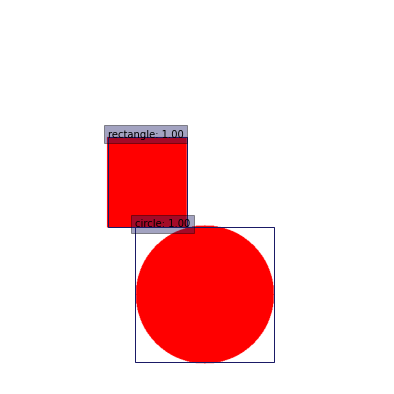

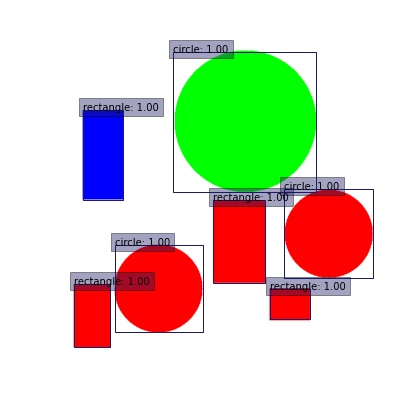

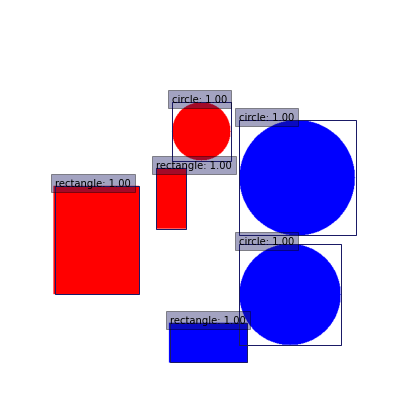

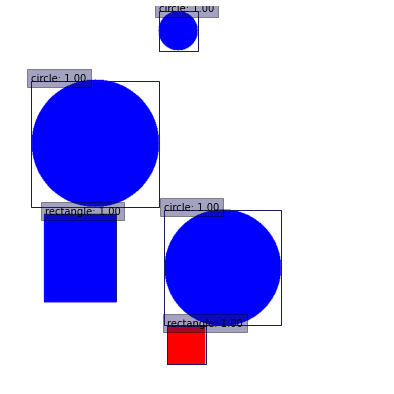

In [29]:
for images, _ in val_dataset.dataset.take(1):
    for i in range(images.shape[0]):
        image = images[i][None, ...]
        detections = serving_fn(image)
        classes = [config.classes[idx] for idx in detections['cls_ids'].numpy()]
        image = (image[0] + config.mean_pixel)[:, :, ::-1]
        fig = visualize_detections(image,
                                   detections['boxes'],
                                   classes,
                                   detections['cls_probs'].numpy())